# SMPy Quickstart: Three Ways to Create Mass Maps

## Learning Objectives
By the end of this tutorial, you will understand SMPy's three API styles (aside from CLI runner):
1. **High-level API**: One-line functions for quick results
2. **Config API**: YAML/dictionary-based for reproducible workflows  
3. **Class API**: Direct mapper access for maximum control

## Prerequisites
- SMPy installed (`pip install .` from the repository root)

## API Overview

SMPy provides three levels of API access to match different use cases:

1. **High-level functional API (Quick)** — Simple one-line functions like `map_mass()` and method-specific variants (`map_kaiser_squires()`, `map_aperture_mass()`, `map_ks_plus()`) that take your data path and parameters directly. These functions handle everything internally: loading data, creating grids, running the mass mapping, and saving outputs. Perfect for quick analysis and exploration.

2. **Configuration-based API (Power Users)** — A more structured approach using `Config` objects and the `run()` function, which separates all analysis parameters from your code. This enables reproducible workflows through YAML files and is ideal for production pipelines where you need to track exactly what parameters produced which results.

3. **Class-based API (Prototyping/Testing)** — Direct access to the coordinate systems, grid creation, and mapper classes for users who need fine-grained control. This low-level API is available when you need to customize the data flow, integrate with existing pipelines, or extend SMPy's functionality. Not necessary for most users.

The full configuration based API is recommended for scientific use to ensure control over full analysis pipeline. 

## Quick Reference

```python
# Simple API (uses defaults)
from smpy import map_mass
result = map_mass(data='catalog.fits', method='kaiser_squires', 
                  coord_system='radec', pixel_scale=0.4)

# Config API (for power users, full configuration)
from smpy.config import Config
from smpy.run import run
config = Config.from_defaults('kaiser_squires')
config.update_from_kwargs(data='catalog.fits', pixel_scale=0.4)
result = run(config)

# Class API (prototyping/testing)
from smpy.mapping_methods import KaiserSquiresMapper
mapper = KaiserSquiresMapper(config_dict)
kappa_e, kappa_b = mapper.create_maps(g1_grid, g2_grid)

In [1]:
# Cell 2: Environment setup
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# SMPy imports - we'll use all API levels
import smpy
from smpy import map_mass, map_kaiser_squires, map_aperture_mass, map_ks_plus
from smpy.config import Config
from smpy.run import run

# Set deterministic seed
SEED = 42
np.random.seed(SEED)

print(f"Python: {sys.version.split()[0]}")
print(f"SMPy: {smpy.__version__}")
print(f"Random seed: {SEED}")

# Set up paths
data_file = Path('../data/forecast_lum_annular.fits')
output_dir = Path('../outputs/quickstart')
output_dir.mkdir(parents=True, exist_ok=True)

Python: 3.12.8
SMPy: 0.5.0
Random seed: 42


## Part 1: Simple API - Get Results Fast

SMPy's simple API is perfect for interactive analysis and notebooks. Each mass mapping method has its own function with sensible defaults.

In [2]:
# Cell 3: Simple API demonstration
# Method 1: The unified map_mass() function - specify method as parameter
result_ks = map_mass(
    data=str(data_file),
    method='kaiser_squires',  # Choose your method
    coord_system='radec',
    pixel_scale=0.4,
    smoothing=2.0,
    g1_col='g1_Rinv',
    g2_col='g2_Rinv',
    weight_col='weight',
    output_dir=str(output_dir / 'simple_api')
)

print("✓ Kaiser-Squires complete")
print(f"  E-mode shape: {result_ks['maps']['E'].shape}")
print(f"  Peak convergence: {result_ks['maps']['E'].max():.3f}")

Convergence map saved as PNG file: ../outputs/quickstart/simple_api/kaiser_squires/smpy_output_kaiser_squires_e_mode.png
✓ Kaiser-Squires complete
  E-mode shape: (38, 57)
  Peak convergence: 0.165


In [3]:
# Cell 4: Method-specific functions
# Method 2: Direct method functions for common use cases
result_am = map_aperture_mass(
    data=str(data_file),
    coord_system='radec',
    pixel_scale=0.4,
    filter_type='schirmer',
    filter_scale=60,
    g1_col='g1_Rinv',
    g2_col='g2_Rinv',
    weight_col='weight',
    output_dir=str(output_dir / 'simple_api')
)

print("✓ Aperture Mass complete")
print(f"  Filter type: Schirmer")

Convergence map saved as PNG file: ../outputs/quickstart/simple_api/aperture_mass/smpy_output_aperture_mass_e_mode.png
✓ Aperture Mass complete
  Filter type: Schirmer


## Part 2: Config API - Reproducible Workflows for Power Users (Recommended)

For production work, SMPy's Config API provides:
- **YAML files** for single-file master configurations
- **Validation** to catch errors before running

In [4]:
# Cell 5: Config-based workflow
# Create a configuration programmatically
config = Config.from_defaults('kaiser_squires')

# Update with our specific parameters
config.update_from_kwargs(
    data=str(data_file),
    coord_system='radec',
    pixel_scale=0.4,
    output_dir=str(output_dir / 'config_api'),
    g1_col='g1_Rinv',
    g2_col='g2_Rinv',
    weight_col='weight',
    smoothing=2.0,
    mode=['E', 'B'],
    create_snr=False
)

# Show what we've configured (general section)
print("Configuration preview:")
config.show_config(section='general')

Configuration preview:
general:
  input_path: ../data/forecast_lum_annular.fits
  input_hdu: 1
  output_directory: ../outputs/quickstart/config_api
  output_base_name: smpy_output
  coordinate_system: radec
  radec:
    resolution: 0.4
    coord1: ra
    coord2: dec
  pixel:
    downsample_factor: 1
    coord1: X_IMAGE
    coord2: Y_IMAGE
    pixel_axis_reference: catalog
  g1_col: g1_Rinv
  g2_col: g2_Rinv
  weight_col: weight
  method: kaiser_squires
  create_snr: false
  create_counts_map: false
  overlay_counts_map: false
  mode:
  - E
  - B
  print_timing: false
  save_fits: false
  _coord_system_set_by_user: true
  _pixel_scale_set_by_user: true



Configurations can be saved as YAML files to serve as both a record of the parameters used to create the map and a reusable configuration file for future runs.

In [5]:
# Cell 6: Run with config and save for reproducibility
# Execute using the configuration
result_config = run(config)

# Save configuration for exact reproduction
config.save_config(output_dir / 'quickstart_config.yaml')

print("✓ Config-based run complete")
print(f"  Config saved to: {output_dir / 'quickstart_config.yaml'}")

Convergence map saved as PNG file: ../outputs/quickstart/config_api/kaiser_squires/smpy_output_kaiser_squires_e_mode.png
Convergence map saved as PNG file: ../outputs/quickstart/config_api/kaiser_squires/smpy_output_kaiser_squires_b_mode.png
Configuration saved to: ../outputs/quickstart/quickstart_config.yaml
✓ Config-based run complete
  Config saved to: ../outputs/quickstart/quickstart_config.yaml


## Part 3 (Optional/Prototyping): Class API - Maximum Control

For advanced users who need fine-grained control, SMPy exposes the mapper classes directly.

In [6]:
# Cell 7: Direct mapper class usage
from smpy.mapping_methods import KaiserSquiresMapper, KSPlusMapper
from smpy.utils import load_shear_data
from smpy.coordinates import get_coordinate_system

# Load and prepare data manually
shear_df = load_shear_data(
    str(data_file),
    coord1_col='ra',
    coord2_col='dec', 
    g1_col='g1_Rinv',
    g2_col='g2_Rinv',
    weight_col='weight',
    hdu=1
)

# Set up coordinate system
coord_system = get_coordinate_system('radec')
shear_df = coord_system.transform_coordinates(shear_df)
scaled_bounds, true_bounds = coord_system.calculate_boundaries(
    shear_df['coord1'].values,
    shear_df['coord2'].values
)

# Create shear grid
g1_grid, g2_grid = coord_system.create_grid(
    shear_df, 
    scaled_bounds,
    {'general': {'radec': {'resolution': 0.4}}}
)

print(f"✓ Manual data preparation complete")
print(f"  Grid shape: {g1_grid.shape}")
print(f"  Number of galaxies: {len(shear_df)}")

✓ Manual data preparation complete
  Grid shape: (38, 57)
  Number of galaxies: 8767


In [7]:
# Cell 8: Use mapper class directly
# Create mapper with custom config
mapper_config = {
    'general': {'method': 'kaiser_squires', 'mode': ['E']},
    'methods': {
        'kaiser_squires': {
            'smoothing': {'type': 'gaussian', 'sigma': 2.0}
        }
    },
    'plotting': {}
}

# Initialize and run mapper
mapper = KaiserSquiresMapper(mapper_config)
kappa_e, kappa_b = mapper.create_maps(g1_grid, -g2_grid)
# Note: -g2 for RA/Dec
# high-level API handles this automatically, but the low-level API expects the user to manage it

print("✓ Direct mapper complete")
print(f"  Convergence range: [{kappa_e.min():.3f}, {kappa_e.max():.3f}]")

✓ Direct mapper complete
  Convergence range: [-0.104, 0.165]


## Comparing the Results

Let's visualize all three methods to confirm they produce equivalent results:

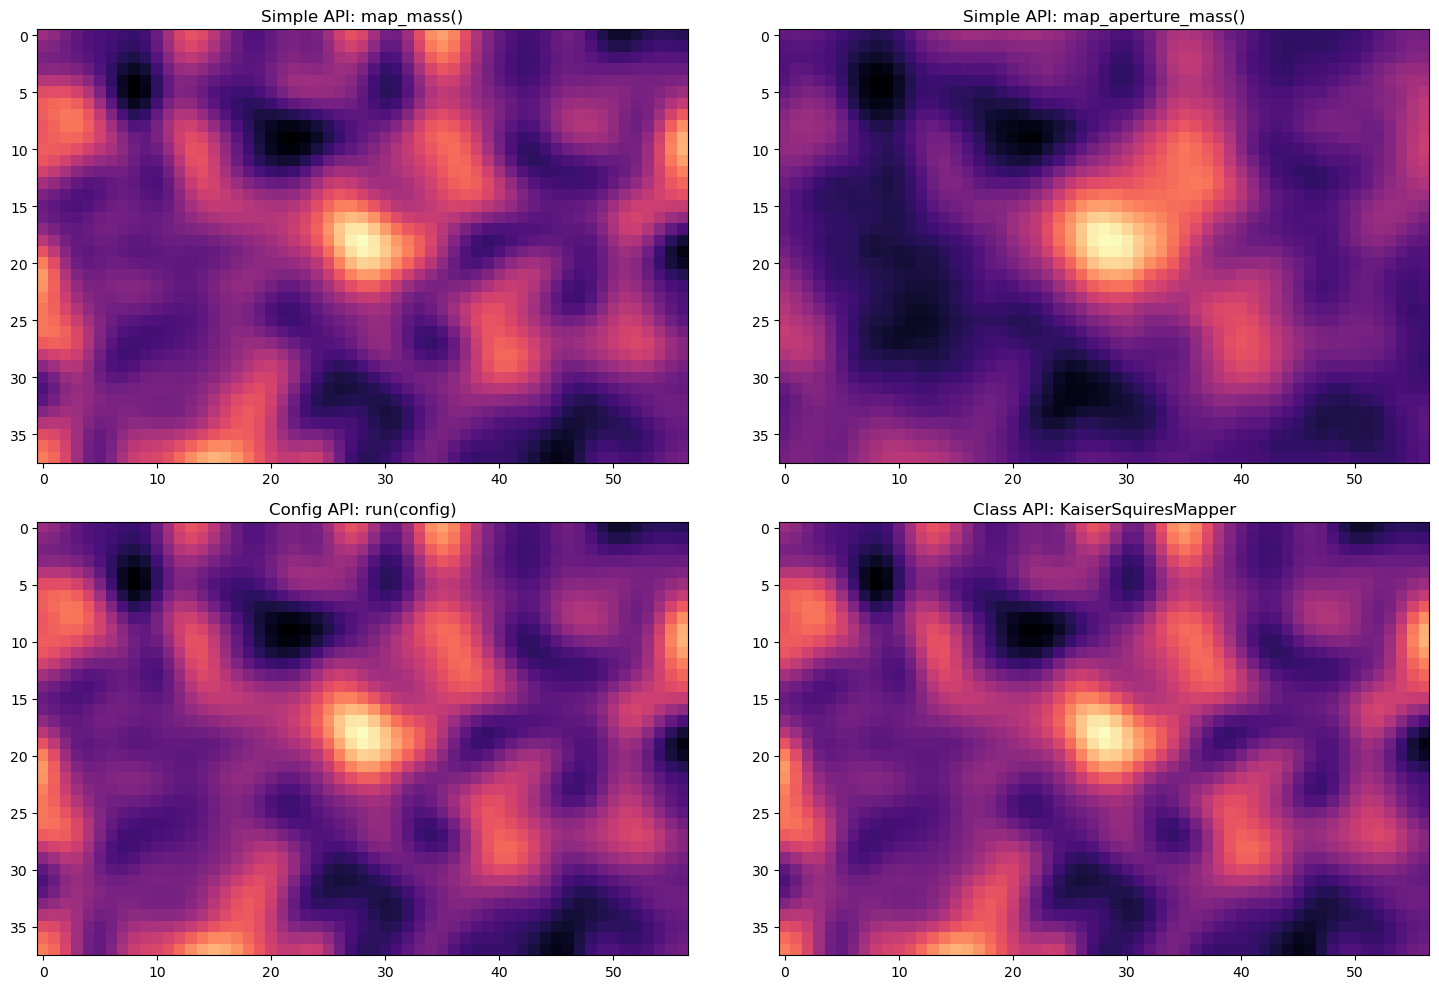

In [8]:
# Cell 9: Comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Simple API results
axes[0, 0].imshow(result_ks['maps']['E'], cmap='magma')
axes[0, 0].set_title('Simple API: map_mass()')

axes[0, 1].imshow(result_am['maps']['E'], cmap='magma')
axes[0, 1].set_title('Simple API: map_aperture_mass()')

# Config API result
axes[1, 0].imshow(result_config['maps']['E'], cmap='magma')
axes[1, 0].set_title('Config API: run(config)')

# Class API result
axes[1, 1].imshow(kappa_e, cmap='magma')
axes[1, 1].set_title('Class API: KaiserSquiresMapper')

plt.tight_layout()
plt.savefig(output_dir / 'api_comparison.png', dpi=150)
plt.show()

# Full Configuration File Example

In [9]:
config.show_config()

general:
  input_path: ../data/forecast_lum_annular.fits
  input_hdu: 1
  output_directory: ../outputs/quickstart/config_api
  output_base_name: smpy_output
  coordinate_system: radec
  radec:
    resolution: 0.4
    coord1: ra
    coord2: dec
  pixel:
    downsample_factor: 1
    coord1: X_IMAGE
    coord2: Y_IMAGE
    pixel_axis_reference: catalog
  g1_col: g1_Rinv
  g2_col: g2_Rinv
  weight_col: weight
  method: kaiser_squires
  create_snr: false
  create_counts_map: false
  overlay_counts_map: false
  mode:
  - E
  - B
  print_timing: false
  save_fits: false
  _coord_system_set_by_user: true
  _pixel_scale_set_by_user: true
methods:
  kaiser_squires:
    smoothing:
      type: gaussian
      sigma: 2.0
  aperture_mass:
    filter:
      type: schirmer
      scale: 60
      truncation: 1.0
      l: 3
  ks_plus:
    inpainting_iterations: 100
    reduced_shear_iterations: 3
    nscales: null
    extension_size: double
    use_wavelet_constraints: true
    constrain_B: false
    thre